In [9]:
import os
import os.path
import cv2
import glob
import imutils
from PIL import Image
from helpers import resize_to_fit
import numpy as np
import tensorflow as tf
import operator
import logging
from keras.models import load_model
logging.getLogger("tensorflow").setLevel(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [10]:
def storeInDictionary(pl, topValue, dikt):
                if pl in dikt.keys() :
                        dikt[pl] = dikt[pl] + topValue
                else:
                        dikt[pl] = topValue
                return dikt  

In [11]:
def give_probabality(test_data):
           
        loaded_graph = tf.Graph()
        
        with tf.Session(graph=loaded_graph) as sess:
            # Load model
            loader = tf.train.import_meta_graph(model_path + '.meta')
            loader.restore(sess, model_path)
        
            # Get Tensors from loaded model
            loaded_x = loaded_graph.get_tensor_by_name('x:0')
            loaded_y = loaded_graph.get_tensor_by_name('y:0')
            loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
            loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
            loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')

            random_test_predictions = sess.run(
                tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
                feed_dict={loaded_x: test_data, loaded_keep_prob: 1.0})
             
            return random_test_predictions

In [12]:
test_dict={0:"2",1:"3",2:"4",3:"5",4:"6",5:"7",6:"8",7:"9",
           8:"A",9:"B",10:"C",11:"D",12:"E",13:"F",14:"G",15:"H",16:"I",17:"J",18:"K",
           19:"a",20:"b",21:"c",22:"d",23:"e",24:"f",25:"g",26:"h",27:"j",28:"k",
           29:"m",30:"n",31:"p",32:"q",33:"r",34:"s",35:"t",36:"u",37:"v",
           38:"w",39:"x",40:"y",41:"z",42:"M",43:"N",44:"P",45:"Q",46:"R",47:"S",
           48:"T",49:"U",50:"V",51:"W",52:"X",53:"Y",54:"Z"}

counts = {}
notfour = 0
count = 0
top_n_predictions = 3

CAPTCHA_IMAGE_FOLDER = "D:/Internship/captcha/TENSORFLOW CODE/test_each/*.png"
model_path = 'D:/Internship/captcha/TENSORFLOW CODE/image_classification'
solved_images = 'D:/Internship/captcha/TENSORFLOW CODE/solved'
MODEL_FILENAME = "D:/Internship/captcha/TENSORFLOW CODE/medium/gap_captcha_model.hdf5"

test_data = np.empty(shape = (1, 35, 25, 1), dtype=np.float)
captcha_image_files_all = glob.glob(CAPTCHA_IMAGE_FOLDER)
model = load_model(MODEL_FILENAME)

In [13]:
def images(captcha_image_files):
    vcount = 0
    tcount=0
    for (file_count, captcha_image_file) in enumerate(captcha_image_files):
        print("[INFO] processing image {}/{}".format(file_count + 1, len(captcha_image_files)))
        # Since the filename contains the captcha text (i.e. "2A2X.png" has the text "2A2X"),
        # grab the base filename as the text
        filename = os.path.basename(captcha_image_file)
        captcha_correct_text = os.path.splitext(filename)[0]
        # Load the image and convert it to grayscale
        image = cv2.imread(captcha_image_file)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Add some extra padding around the image
        gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
        # threshold the image (convert it to pure black and white)
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # find the contours (continuous blobs of pixels) the image
        contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Hack for compatibility with different OpenCV versions
        contours = contours[0] if imutils.is_cv2() else contours[1]
        letter_image_regions = []
        merged_letter_image_regions = []
        final_letter_image_regions = []
        # Now we can loop through each of the four contours and extract the letter
        # inside of each one
        for contour in contours:
            # Get the rectangle that contains the contour
            (x, y, w, h) = cv2.boundingRect(contour)
            if  w>3 and h>10:
                letter_image_regions.append((x, y, w, h))
        letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
        regions_length = len(letter_image_regions)
        merged_letter_image_regions = []
        i=0
        widths = []
        while i < regions_length:
            
             if i+1 == regions_length: 
                 if letter_image_regions[i] not in  merged_letter_image_regions: 
                     merged_letter_image_regions.append(letter_image_regions[i]) 
                     widths.append(letter_image_regions[i][2]) 
                 break
                
             adjacent_region_gap = letter_image_regions[i+1][0] - letter_image_regions[i][0]
            
             if(adjacent_region_gap<=5):
               if(letter_image_regions[i][2]> letter_image_regions[i+1][2] and letter_image_regions[i] not in  merged_letter_image_regions):
                 merged_letter_image_regions.append(letter_image_regions[i])
                 widths.append(letter_image_regions[i][2]) 
               elif(letter_image_regions[i+1][2]> letter_image_regions[i][2] and letter_image_regions[i+1] not in  merged_letter_image_regions):
                 merged_letter_image_regions.append(letter_image_regions[i+1])
                 widths.append(letter_image_regions[i+1][2]) 
               i+=2
             else:
                if letter_image_regions[i] not in  merged_letter_image_regions :
                    merged_letter_image_regions.append(letter_image_regions[i])
                    widths.append(letter_image_regions[i][2]) 
                merged_letter_image_regions.append(letter_image_regions[i+1])    
                widths.append(letter_image_regions[i+1][2]) 
                i+=1

        average_width = sum(widths)/4
        t_width = letter_image_regions[-1][0] + letter_image_regions[-1][2] - letter_image_regions[0][0]
        img = cv2.resize(gray,(120,40))
        img = np.reshape(img,[1,40,120,1])
        img_class = model.predict_classes(img)
        if average_width <= 20:
            if img_class == 1:
                continue
                
        tcount+=1

        final_letter_image_regions = []
        for letter_bounding_box in merged_letter_image_regions:
            # Grab the coordinates of the letter in the image
            x, y, w, h = letter_bounding_box

            if w/average_width> 3.5:
                half_width = int(w / 4)
                final_letter_image_regions.append((x, y, half_width, h))
                final_letter_image_regions.append((x + half_width, y, half_width, h)) 
                final_letter_image_regions.append((x + 2*half_width, y, half_width, h))        
                final_letter_image_regions.append((x + 3*half_width, y, half_width, h))        
            elif w/average_width> 2.37:
                half_width = int(w / 3)
                final_letter_image_regions.append((x, y, half_width, h))
                final_letter_image_regions.append((x + half_width, y, half_width, h)) 
                final_letter_image_regions.append((x + 2*half_width, y, half_width, h))
            elif w/average_width> 1.5:
                half_width = int(w / 2)
                final_letter_image_regions.append((x, y, half_width, h))
                final_letter_image_regions.append((x + half_width, y, half_width, h))
            else:
                # This is a normal letter by itself
                final_letter_image_regions.append((x, y, w, h))
        final_letter_image_regions2 = []
        if len(final_letter_image_regions) == 2:

            for letter_bounding_box in final_letter_image_regions:
            # Grab the coordinates of the letter in the image
                x, y, w, h = letter_bounding_box
                half_width = int(w / 2)
                final_letter_image_regions2.append((x, y, half_width, h))
                final_letter_image_regions2.append((x + half_width, y, half_width, h))

            final_letter_image_regions = final_letter_image_regions2    
        output = cv2.merge([gray] * 3)        
        predictions1 = [] 
    #    # Save out each letter as a single image
        for letter_bounding_box, letter_text in zip(final_letter_image_regions, captcha_correct_text):
    #        # Grab the coordinates of the letter in the image
            x, y, w, h = letter_bounding_box
            delta_width = 0
            loop_counter = 0
            dikt = {}
            output = cv2.rectangle(output, (int(x), int(y)), (int(x) + int(w), int(y) + int(h)), (0, 255, 0), 1)

            while True:

                    if x-delta_width>=0 and y-2>=0:

                        letter_image = gray[y-2:y + h+2, int(x-delta_width):int(x + w-delta_width )]

                    elif x-delta_width>=0 and y-1>=0:
                        letter_image = gray[y-1:y + h+2, int(x-delta_width):int(x + w-delta_width )]

                    else:
                        letter_image = gray[y:y + h+2, int(x):int(x + w-delta_width )]

                    letter_image = resize_to_fit(letter_image, 25, 35)

                    arr = np.array(letter_image)
                    arr = arr.astype(float)
                    arr = arr*1/arr.max()

                    test_data[0,:, :, 0] = arr
                    random_test_predictions = give_probabality(test_data)

                    if delta_width < 4 and delta_width >=0:
                        delta_width = delta_width + 1
                    elif delta_width >= 4:
                        delta_width = -1
                    else:
                        delta_width = delta_width - 1

                    topValue = random_test_predictions.values[0,0]
                    topValue2 = random_test_predictions.values[0,1]
                    topValue3 = random_test_predictions.values[0,2]
                    pl = random_test_predictions.indices[0,0]
                    pl2 = random_test_predictions.indices[0,1]
                    pl3 = random_test_predictions.indices[0,2]
                    loop_counter +=1 

                    dikt = storeInDictionary(pl, topValue, dikt)
                    dikt = storeInDictionary(pl2, topValue2, dikt)
                    dikt = storeInDictionary(pl3, topValue3, dikt)

                    pl = test_dict[pl]

                    if loop_counter >=8:
                       pl = dict(sorted(dikt.items(), key=operator.itemgetter(1), reverse=True)[:2])
                       ind = [x for x in pl]
                       predictions1.append(test_dict[ind[0]])
                       break

        p = os.path.join(solved_images, "{}".format(filename))
        cv2.imwrite(p, output)
        display(Image.open(p))            
        captcha_text = "".join(predictions1)                
        print("Actual Text:", captcha_correct_text)
        print("Predicted Text: ",captcha_text)
        if (np.char.lower(captcha_text) == np.char.lower(captcha_correct_text)):
            print("...........................MATCH.............................")
            vcount+=1
        print("matches so far : {}/{}".format(vcount,tcount))

    print("accuracy: >>>>>>>>>>>>>>>>>>>>>>>>>>>> ", vcount/tcount)


[INFO] processing image 1/400


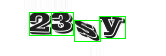

Actual Text: 23sy
Predicted Text:  23sy
...........................MATCH.............................
matches so far : 1/1
[INFO] processing image 2/400


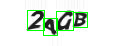

Actual Text: 24GB
Predicted Text:  24GB
...........................MATCH.............................
matches so far : 2/2
[INFO] processing image 3/400


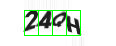

Actual Text: 24QH
Predicted Text:  24QH
...........................MATCH.............................
matches so far : 3/3
[INFO] processing image 4/400


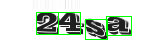

Actual Text: 24sa
Predicted Text:  24sa
...........................MATCH.............................
matches so far : 4/4
[INFO] processing image 5/400


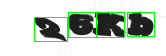

Actual Text: 26Kb
Predicted Text:  26Kb
...........................MATCH.............................
matches so far : 5/5
[INFO] processing image 6/400


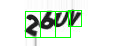

Actual Text: 26UV
Predicted Text:  26UV
...........................MATCH.............................
matches so far : 6/6
[INFO] processing image 7/400


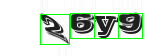

Actual Text: 26y9
Predicted Text:  26y9
...........................MATCH.............................
matches so far : 7/7
[INFO] processing image 8/400


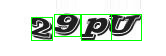

Actual Text: 29pU
Predicted Text:  29pU
...........................MATCH.............................
matches so far : 8/8
[INFO] processing image 9/400
[INFO] processing image 10/400
[INFO] processing image 11/400
[INFO] processing image 12/400
[INFO] processing image 13/400


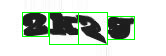

Actual Text: 2k2g
Predicted Text:  2k2g
...........................MATCH.............................
matches so far : 9/9
[INFO] processing image 14/400


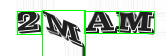

Actual Text: 2MAM
Predicted Text:  2MAM
...........................MATCH.............................
matches so far : 10/10
[INFO] processing image 15/400


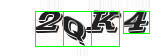

Actual Text: 2QK4
Predicted Text:  2QK4
...........................MATCH.............................
matches so far : 11/11
[INFO] processing image 16/400


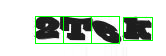

Actual Text: 2T6K
Predicted Text:  2T6k
...........................MATCH.............................
matches so far : 12/12
[INFO] processing image 17/400


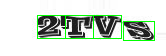

Actual Text: 2TVS
Predicted Text:  2TVs
...........................MATCH.............................
matches so far : 13/13
[INFO] processing image 18/400


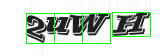

Actual Text: 2uwh
Predicted Text:  2uWH
...........................MATCH.............................
matches so far : 14/14
[INFO] processing image 19/400


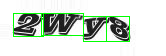

Actual Text: 2Wy8
Predicted Text:  2Wy8
...........................MATCH.............................
matches so far : 15/15
[INFO] processing image 20/400


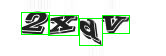

Actual Text: 2xdv
Predicted Text:  2xdv
...........................MATCH.............................
matches so far : 16/16
[INFO] processing image 21/400


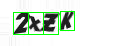

Actual Text: 2XZK
Predicted Text:  2XZK
...........................MATCH.............................
matches so far : 17/17
[INFO] processing image 22/400


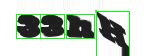

Actual Text: 33hH
Predicted Text:  33hH
...........................MATCH.............................
matches so far : 18/18
[INFO] processing image 23/400


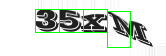

Actual Text: 35xm
Predicted Text:  35xM
...........................MATCH.............................
matches so far : 19/19
[INFO] processing image 24/400


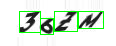

Actual Text: 36ZM
Predicted Text:  36ZM
...........................MATCH.............................
matches so far : 20/20
[INFO] processing image 25/400


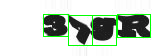

Actual Text: 37gR
Predicted Text:  37gR
...........................MATCH.............................
matches so far : 21/21
[INFO] processing image 26/400


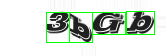

Actual Text: 3BGB
Predicted Text:  3bGb
...........................MATCH.............................
matches so far : 22/22
[INFO] processing image 27/400


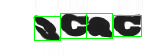

Actual Text: 3cac
Predicted Text:  3caC
...........................MATCH.............................
matches so far : 23/23
[INFO] processing image 28/400


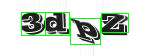

Actual Text: 3dpz
Predicted Text:  3dpZ
...........................MATCH.............................
matches so far : 24/24
[INFO] processing image 29/400
[INFO] processing image 30/400


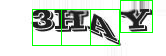

Actual Text: 3HAY
Predicted Text:  3HAY
...........................MATCH.............................
matches so far : 25/25
[INFO] processing image 31/400
[INFO] processing image 32/400


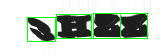

Actual Text: 3HZZ
Predicted Text:  3HZZ
...........................MATCH.............................
matches so far : 26/26
[INFO] processing image 33/400


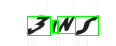

Actual Text: 3INS
Predicted Text:  3INS
...........................MATCH.............................
matches so far : 27/27
[INFO] processing image 34/400
[INFO] processing image 35/400


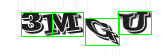

Actual Text: 3MGU
Predicted Text:  3MGU
...........................MATCH.............................
matches so far : 28/28
[INFO] processing image 36/400


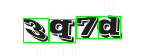

Actual Text: 3q7d
Predicted Text:  3q7d
...........................MATCH.............................
matches so far : 29/29
[INFO] processing image 37/400


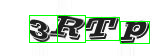

Actual Text: 3RTp
Predicted Text:  3RTp
...........................MATCH.............................
matches so far : 30/30
[INFO] processing image 38/400


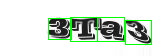

Actual Text: 3Ta3
Predicted Text:  3Ta3
...........................MATCH.............................
matches so far : 31/31
[INFO] processing image 39/400


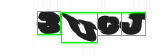

Actual Text: 3UcJ
Predicted Text:  3UcJ
...........................MATCH.............................
matches so far : 32/32
[INFO] processing image 40/400


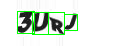

Actual Text: 3URJ
Predicted Text:  3URJ
...........................MATCH.............................
matches so far : 33/33
[INFO] processing image 41/400


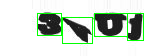

Actual Text: 3VUj
Predicted Text:  3vUj
...........................MATCH.............................
matches so far : 34/34
[INFO] processing image 42/400


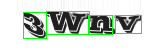

Actual Text: 3Wnv
Predicted Text:  3Wnv
...........................MATCH.............................
matches so far : 35/35
[INFO] processing image 43/400


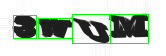

Actual Text: 3wum
Predicted Text:  3wUM
...........................MATCH.............................
matches so far : 36/36
[INFO] processing image 44/400


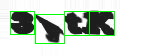

Actual Text: 3ytK
Predicted Text:  3ytK
...........................MATCH.............................
matches so far : 37/37
[INFO] processing image 45/400


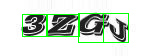

Actual Text: 3ZGJ
Predicted Text:  3ZGM
matches so far : 37/38
[INFO] processing image 46/400


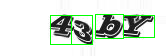

Actual Text: 43bY
Predicted Text:  43bY
...........................MATCH.............................
matches so far : 38/39
[INFO] processing image 47/400


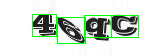

Actual Text: 46qC
Predicted Text:  46qC
...........................MATCH.............................
matches so far : 39/40
[INFO] processing image 48/400


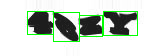

Actual Text: 48zY
Predicted Text:  48ZY
...........................MATCH.............................
matches so far : 40/41
[INFO] processing image 49/400


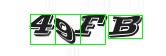

Actual Text: 49FB
Predicted Text:  49FB
...........................MATCH.............................
matches so far : 41/42
[INFO] processing image 50/400


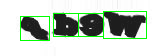

Actual Text: 4b9W
Predicted Text:  4b9W
...........................MATCH.............................
matches so far : 42/43
[INFO] processing image 51/400
[INFO] processing image 52/400


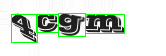

Actual Text: 4cgm
Predicted Text:  4cgm
...........................MATCH.............................
matches so far : 43/44
[INFO] processing image 53/400


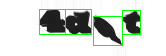

Actual Text: 4dat
Predicted Text:  4dat
...........................MATCH.............................
matches so far : 44/45
[INFO] processing image 54/400
[INFO] processing image 55/400
[INFO] processing image 56/400


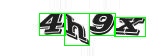

Actual Text: 4h9x
Predicted Text:  4h9x
...........................MATCH.............................
matches so far : 45/46
[INFO] processing image 57/400


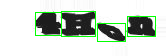

Actual Text: 4Hcn
Predicted Text:  4Hcn
...........................MATCH.............................
matches so far : 46/47
[INFO] processing image 58/400


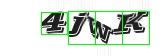

Actual Text: 4jwK
Predicted Text:  4jwK
...........................MATCH.............................
matches so far : 47/48
[INFO] processing image 59/400


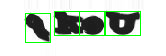

Actual Text: 4k9U
Predicted Text:  4k9U
...........................MATCH.............................
matches so far : 48/49
[INFO] processing image 60/400


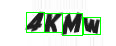

Actual Text: 4KMW
Predicted Text:  4KMW
...........................MATCH.............................
matches so far : 49/50
[INFO] processing image 61/400
[INFO] processing image 62/400


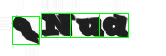

Actual Text: 4Nud
Predicted Text:  4Nmd
matches so far : 49/51
[INFO] processing image 63/400


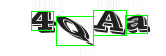

Actual Text: 4QAa
Predicted Text:  4QAa
...........................MATCH.............................
matches so far : 50/52
[INFO] processing image 64/400


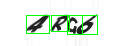

Actual Text: 4RG6
Predicted Text:  4RG6
...........................MATCH.............................
matches so far : 51/53
[INFO] processing image 65/400


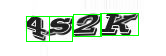

Actual Text: 4s2K
Predicted Text:  4s2K
...........................MATCH.............................
matches so far : 52/54
[INFO] processing image 66/400


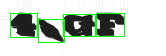

Actual Text: 4sGF
Predicted Text:  4AGF
matches so far : 52/55
[INFO] processing image 67/400


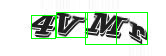

Actual Text: 4VMr
Predicted Text:  4VMr
...........................MATCH.............................
matches so far : 53/56
[INFO] processing image 68/400


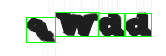

Actual Text: 4Wdd
Predicted Text:  4Wdd
...........................MATCH.............................
matches so far : 54/57
[INFO] processing image 69/400


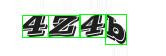

Actual Text: 4Z4b
Predicted Text:  4Z4b
...........................MATCH.............................
matches so far : 55/58
[INFO] processing image 70/400


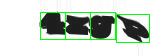

Actual Text: 4zgp
Predicted Text:  4ZgP
...........................MATCH.............................
matches so far : 56/59
[INFO] processing image 71/400


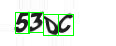

Actual Text: 53DC
Predicted Text:  53DC
...........................MATCH.............................
matches so far : 57/60
[INFO] processing image 72/400


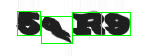

Actual Text: 54R9
Predicted Text:  54R9
...........................MATCH.............................
matches so far : 58/61
[INFO] processing image 73/400


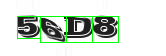

Actual Text: 56D8
Predicted Text:  56D8
...........................MATCH.............................
matches so far : 59/62
[INFO] processing image 74/400


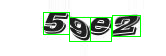

Actual Text: 59e2
Predicted Text:  59e2
...........................MATCH.............................
matches so far : 60/63
[INFO] processing image 75/400


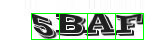

Actual Text: 5BAF
Predicted Text:  5BAF
...........................MATCH.............................
matches so far : 61/64
[INFO] processing image 76/400
[INFO] processing image 77/400
[INFO] processing image 78/400


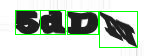

Actual Text: 5dDN
Predicted Text:  5dDN
...........................MATCH.............................
matches so far : 62/65
[INFO] processing image 79/400


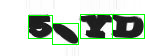

Actual Text: 5eYD
Predicted Text:  5eYD
...........................MATCH.............................
matches so far : 63/66
[INFO] processing image 80/400


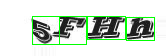

Actual Text: 5FHh
Predicted Text:  5FHh
...........................MATCH.............................
matches so far : 64/67
[INFO] processing image 81/400
[INFO] processing image 82/400


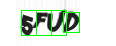

Actual Text: 5FUD
Predicted Text:  5FUD
...........................MATCH.............................
matches so far : 65/68
[INFO] processing image 83/400


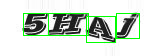

Actual Text: 5HAj
Predicted Text:  5HAj
...........................MATCH.............................
matches so far : 66/69
[INFO] processing image 84/400


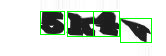

Actual Text: 5k4v
Predicted Text:  5k4v
...........................MATCH.............................
matches so far : 67/70
[INFO] processing image 85/400


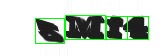

Actual Text: 5mf4
Predicted Text:  5Mf4
...........................MATCH.............................
matches so far : 68/71
[INFO] processing image 86/400


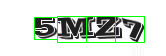

Actual Text: 5MZ7
Predicted Text:  5MH7
matches so far : 68/72
[INFO] processing image 87/400


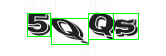

Actual Text: 5QQS
Predicted Text:  5QQS
...........................MATCH.............................
matches so far : 69/73
[INFO] processing image 88/400


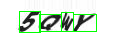

Actual Text: 5QWY
Predicted Text:  5QWY
...........................MATCH.............................
matches so far : 70/74
[INFO] processing image 89/400


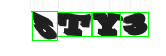

Actual Text: 5TY3
Predicted Text:  5TY3
...........................MATCH.............................
matches so far : 71/75
[INFO] processing image 90/400


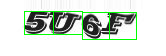

Actual Text: 5U6F
Predicted Text:  5U6F
...........................MATCH.............................
matches so far : 72/76
[INFO] processing image 91/400
[INFO] processing image 92/400
[INFO] processing image 93/400


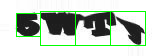

Actual Text: 5WTy
Predicted Text:  5WTy
...........................MATCH.............................
matches so far : 73/77
[INFO] processing image 94/400


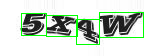

Actual Text: 5X4W
Predicted Text:  5x4W
...........................MATCH.............................
matches so far : 74/78
[INFO] processing image 95/400
[INFO] processing image 96/400


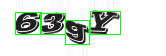

Actual Text: 63gY
Predicted Text:  63gY
...........................MATCH.............................
matches so far : 75/79
[INFO] processing image 97/400


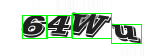

Actual Text: 64wu
Predicted Text:  64Wu
...........................MATCH.............................
matches so far : 76/80
[INFO] processing image 98/400


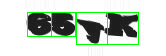

Actual Text: 65yK
Predicted Text:  65yK
...........................MATCH.............................
matches so far : 77/81
[INFO] processing image 99/400


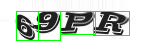

Actual Text: 69PR
Predicted Text:  69PR
...........................MATCH.............................
matches so far : 78/82
[INFO] processing image 100/400


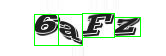

Actual Text: 6aFz
Predicted Text:  6aFZ
...........................MATCH.............................
matches so far : 79/83
[INFO] processing image 101/400
[INFO] processing image 102/400


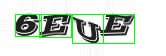

Actual Text: 6EUE
Predicted Text:  6EUE
...........................MATCH.............................
matches so far : 80/84
[INFO] processing image 103/400


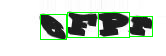

Actual Text: 6FPr
Predicted Text:  6FPr
...........................MATCH.............................
matches so far : 81/85
[INFO] processing image 104/400


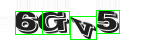

Actual Text: 6Gv5
Predicted Text:  6Gv5
...........................MATCH.............................
matches so far : 82/86
[INFO] processing image 105/400


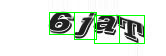

Actual Text: 6jat
Predicted Text:  6jaT
...........................MATCH.............................
matches so far : 83/87
[INFO] processing image 106/400


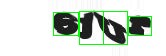

Actual Text: 6jUr
Predicted Text:  6fUr
matches so far : 83/88
[INFO] processing image 107/400


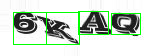

Actual Text: 6KAQ
Predicted Text:  6KAQ
...........................MATCH.............................
matches so far : 84/89
[INFO] processing image 108/400
[INFO] processing image 109/400
[INFO] processing image 110/400


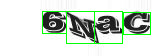

Actual Text: 6NaC
Predicted Text:  6NaC
...........................MATCH.............................
matches so far : 85/90
[INFO] processing image 111/400
[INFO] processing image 112/400


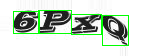

Actual Text: 6PXQ
Predicted Text:  6PxQ
...........................MATCH.............................
matches so far : 86/91
[INFO] processing image 113/400


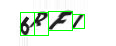

Actual Text: 6RFI
Predicted Text:  6RFI
...........................MATCH.............................
matches so far : 87/92
[INFO] processing image 114/400


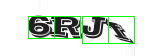

Actual Text: 6RJf
Predicted Text:  6RJf
...........................MATCH.............................
matches so far : 88/93
[INFO] processing image 115/400


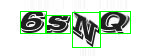

Actual Text: 6sNQ
Predicted Text:  6sNQ
...........................MATCH.............................
matches so far : 89/94
[INFO] processing image 116/400


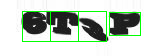

Actual Text: 6T3P
Predicted Text:  6T3P
...........................MATCH.............................
matches so far : 90/95
[INFO] processing image 117/400


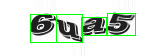

Actual Text: 6ua5
Predicted Text:  6ua5
...........................MATCH.............................
matches so far : 91/96
[INFO] processing image 118/400


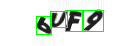

Actual Text: 6UF9
Predicted Text:  6UF9
...........................MATCH.............................
matches so far : 92/97
[INFO] processing image 119/400


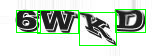

Actual Text: 6WKD
Predicted Text:  6WKD
...........................MATCH.............................
matches so far : 93/98
[INFO] processing image 120/400


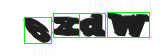

Actual Text: 6xdW
Predicted Text:  6xdW
...........................MATCH.............................
matches so far : 94/99
[INFO] processing image 121/400


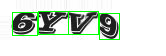

Actual Text: 6YV9
Predicted Text:  6YV9
...........................MATCH.............................
matches so far : 95/100
[INFO] processing image 122/400


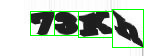

Actual Text: 73Kh
Predicted Text:  73kh
...........................MATCH.............................
matches so far : 96/101
[INFO] processing image 123/400


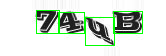

Actual Text: 74ub
Predicted Text:  74uB
...........................MATCH.............................
matches so far : 97/102
[INFO] processing image 124/400


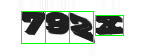

Actual Text: 792x
Predicted Text:  792x
...........................MATCH.............................
matches so far : 98/103
[INFO] processing image 125/400


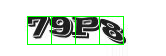

Actual Text: 79P8
Predicted Text:  79P8
...........................MATCH.............................
matches so far : 99/104
[INFO] processing image 126/400
[INFO] processing image 127/400
[INFO] processing image 128/400
[INFO] processing image 129/400


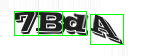

Actual Text: 7BdA
Predicted Text:  7BdA
...........................MATCH.............................
matches so far : 100/105
[INFO] processing image 130/400
[INFO] processing image 131/400


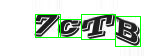

Actual Text: 7cTB
Predicted Text:  7cTB
...........................MATCH.............................
matches so far : 101/106
[INFO] processing image 132/400


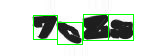

Actual Text: 7cZs
Predicted Text:  7cZs
...........................MATCH.............................
matches so far : 102/107
[INFO] processing image 133/400


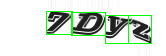

Actual Text: 7Dyz
Predicted Text:  7DyZ
...........................MATCH.............................
matches so far : 103/108
[INFO] processing image 134/400


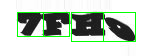

Actual Text: 7FH9
Predicted Text:  7FH9
...........................MATCH.............................
matches so far : 104/109
[INFO] processing image 135/400


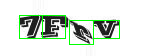

Actual Text: 7Frv
Predicted Text:  7FrV
...........................MATCH.............................
matches so far : 105/110
[INFO] processing image 136/400


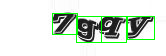

Actual Text: 7gqy
Predicted Text:  7gqy
...........................MATCH.............................
matches so far : 106/111
[INFO] processing image 137/400
[INFO] processing image 138/400


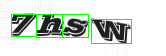

Actual Text: 7hsw
Predicted Text:  7hsW
...........................MATCH.............................
matches so far : 107/112
[INFO] processing image 139/400


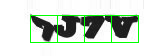

Actual Text: 7J7v
Predicted Text:  7J7V
...........................MATCH.............................
matches so far : 108/113
[INFO] processing image 140/400


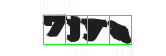

Actual Text: 7jys
Predicted Text:  7jys
...........................MATCH.............................
matches so far : 109/114
[INFO] processing image 141/400


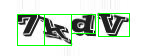

Actual Text: 7KdV
Predicted Text:  7kdV
...........................MATCH.............................
matches so far : 110/115
[INFO] processing image 142/400
[INFO] processing image 143/400


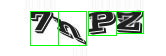

Actual Text: 7npz
Predicted Text:  7nPZ
...........................MATCH.............................
matches so far : 111/116
[INFO] processing image 144/400


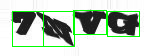

Actual Text: 7NVG
Predicted Text:  7NVG
...........................MATCH.............................
matches so far : 112/117
[INFO] processing image 145/400


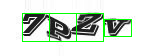

Actual Text: 7PZV
Predicted Text:  7PZV
...........................MATCH.............................
matches so far : 113/118
[INFO] processing image 146/400


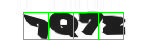

Actual Text: 7Q7z
Predicted Text:  7QDH
matches so far : 113/119
[INFO] processing image 147/400


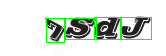

Actual Text: 7SdJ
Predicted Text:  7SdJ
...........................MATCH.............................
matches so far : 114/120
[INFO] processing image 148/400
[INFO] processing image 149/400


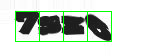

Actual Text: 7sz6
Predicted Text:  7sZ6
...........................MATCH.............................
matches so far : 115/121
[INFO] processing image 150/400


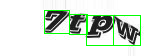

Actual Text: 7tpw
Predicted Text:  7tpW
...........................MATCH.............................
matches so far : 116/122
[INFO] processing image 151/400


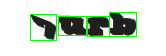

Actual Text: 7urb
Predicted Text:  7urb
...........................MATCH.............................
matches so far : 117/123
[INFO] processing image 152/400


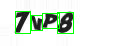

Actual Text: 7VP8
Predicted Text:  7VP8
...........................MATCH.............................
matches so far : 118/124
[INFO] processing image 153/400


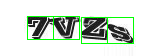

Actual Text: 7VZs
Predicted Text:  7VZs
...........................MATCH.............................
matches so far : 119/125
[INFO] processing image 154/400


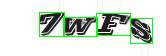

Actual Text: 7WFS
Predicted Text:  7WFS
...........................MATCH.............................
matches so far : 120/126
[INFO] processing image 155/400


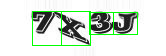

Actual Text: 7x3j
Predicted Text:  7X3J
...........................MATCH.............................
matches so far : 121/127
[INFO] processing image 156/400


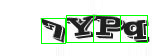

Actual Text: 7YPq
Predicted Text:  7YPq
...........................MATCH.............................
matches so far : 122/128
[INFO] processing image 157/400


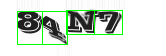

Actual Text: 84N7
Predicted Text:  84N7
...........................MATCH.............................
matches so far : 123/129
[INFO] processing image 158/400


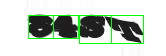

Actual Text: 84ST
Predicted Text:  84ST
...........................MATCH.............................
matches so far : 124/130
[INFO] processing image 159/400


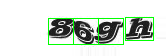

Actual Text: 86gh
Predicted Text:  86gh
...........................MATCH.............................
matches so far : 125/131
[INFO] processing image 160/400


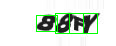

Actual Text: 88FY
Predicted Text:  88kY
matches so far : 125/132
[INFO] processing image 161/400


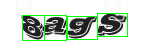

Actual Text: 8agS
Predicted Text:  8agS
...........................MATCH.............................
matches so far : 126/133
[INFO] processing image 162/400


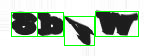

Actual Text: 8byW
Predicted Text:  8byW
...........................MATCH.............................
matches so far : 127/134
[INFO] processing image 163/400


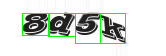

Actual Text: 8d5k
Predicted Text:  8d5k
...........................MATCH.............................
matches so far : 128/135
[INFO] processing image 164/400


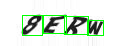

Actual Text: 8ERW
Predicted Text:  8ERW
...........................MATCH.............................
matches so far : 129/136
[INFO] processing image 165/400


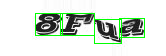

Actual Text: 8fua
Predicted Text:  8Fua
...........................MATCH.............................
matches so far : 130/137
[INFO] processing image 166/400


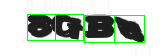

Actual Text: 8GBs
Predicted Text:  8GBs
...........................MATCH.............................
matches so far : 131/138
[INFO] processing image 167/400


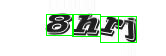

Actual Text: 8hrj
Predicted Text:  8hrj
...........................MATCH.............................
matches so far : 132/139
[INFO] processing image 168/400


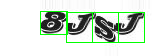

Actual Text: 8JSJ
Predicted Text:  8JSJ
...........................MATCH.............................
matches so far : 133/140
[INFO] processing image 169/400


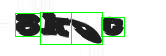

Actual Text: 8k9c
Predicted Text:  8k9c
...........................MATCH.............................
matches so far : 134/141
[INFO] processing image 170/400


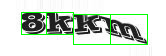

Actual Text: 8kkm
Predicted Text:  8kFm
matches so far : 134/142
[INFO] processing image 171/400


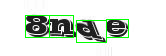

Actual Text: 8nde
Predicted Text:  8nde
...........................MATCH.............................
matches so far : 135/143
[INFO] processing image 172/400


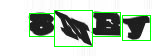

Actual Text: 8NEy
Predicted Text:  8NEy
...........................MATCH.............................
matches so far : 136/144
[INFO] processing image 173/400


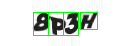

Actual Text: 8P3H
Predicted Text:  8P3H
...........................MATCH.............................
matches so far : 137/145
[INFO] processing image 174/400


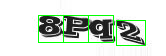

Actual Text: 8Pq2
Predicted Text:  8Pq2
...........................MATCH.............................
matches so far : 138/146
[INFO] processing image 175/400


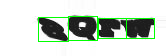

Actual Text: 8qrw
Predicted Text:  8QrW
...........................MATCH.............................
matches so far : 139/147
[INFO] processing image 176/400


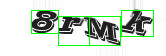

Actual Text: 8rMk
Predicted Text:  8rMk
...........................MATCH.............................
matches so far : 140/148
[INFO] processing image 177/400


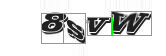

Actual Text: 8svW
Predicted Text:  8SvW
...........................MATCH.............................
matches so far : 141/149
[INFO] processing image 178/400


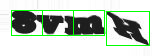

Actual Text: 8vmH
Predicted Text:  8WmH
matches so far : 141/150
[INFO] processing image 179/400


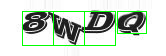

Actual Text: 8WDQ
Predicted Text:  8WDQ
...........................MATCH.............................
matches so far : 142/151
[INFO] processing image 180/400


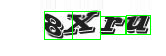

Actual Text: 8Xru
Predicted Text:  8Xru
...........................MATCH.............................
matches so far : 143/152
[INFO] processing image 181/400


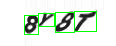

Actual Text: 8Y8T
Predicted Text:  8Y8T
...........................MATCH.............................
matches so far : 144/153
[INFO] processing image 182/400


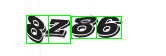

Actual Text: 8Z86
Predicted Text:  8Z86
...........................MATCH.............................
matches so far : 145/154
[INFO] processing image 183/400


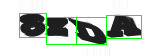

Actual Text: 8zda
Predicted Text:  8ZDA
...........................MATCH.............................
matches so far : 146/155
[INFO] processing image 184/400


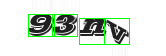

Actual Text: 93nv
Predicted Text:  93nW
matches so far : 146/156
[INFO] processing image 185/400


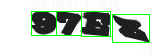

Actual Text: 97eZ
Predicted Text:  97EZ
...........................MATCH.............................
matches so far : 147/157
[INFO] processing image 186/400


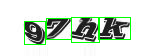

Actual Text: 97hk
Predicted Text:  97hk
...........................MATCH.............................
matches so far : 148/158
[INFO] processing image 187/400


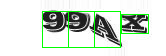

Actual Text: 99Ax
Predicted Text:  99Ax
...........................MATCH.............................
matches so far : 149/159
[INFO] processing image 188/400


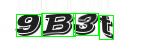

Actual Text: 9B3t
Predicted Text:  9B3t
...........................MATCH.............................
matches so far : 150/160
[INFO] processing image 189/400


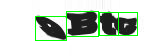

Actual Text: 9Btc
Predicted Text:  9Btc
...........................MATCH.............................
matches so far : 151/161
[INFO] processing image 190/400


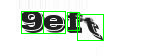

Actual Text: 9eft
Predicted Text:  9efN
matches so far : 151/162
[INFO] processing image 191/400


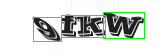

Actual Text: 9fkW
Predicted Text:  9fkW
...........................MATCH.............................
matches so far : 152/163
[INFO] processing image 192/400


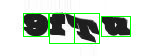

Actual Text: 9fTu
Predicted Text:  9fTu
...........................MATCH.............................
matches so far : 153/164
[INFO] processing image 193/400


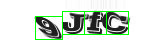

Actual Text: 9jfc
Predicted Text:  9Jfc
...........................MATCH.............................
matches so far : 154/165
[INFO] processing image 194/400


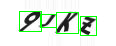

Actual Text: 9JKZ
Predicted Text:  9JKZ
...........................MATCH.............................
matches so far : 155/166
[INFO] processing image 195/400


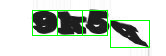

Actual Text: 9k5q
Predicted Text:  9k54
matches so far : 155/167
[INFO] processing image 196/400


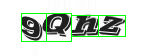

Actual Text: 9QhZ
Predicted Text:  9QhZ
...........................MATCH.............................
matches so far : 156/168
[INFO] processing image 197/400


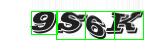

Actual Text: 9S6K
Predicted Text:  9S6K
...........................MATCH.............................
matches so far : 157/169
[INFO] processing image 198/400


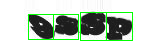

Actual Text: 9sSp
Predicted Text:  9sSp
...........................MATCH.............................
matches so far : 158/170
[INFO] processing image 199/400


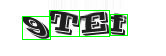

Actual Text: 9TEf
Predicted Text:  9TEf
...........................MATCH.............................
matches so far : 159/171
[INFO] processing image 200/400


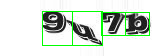

Actual Text: 9u7b
Predicted Text:  9u7b
...........................MATCH.............................
matches so far : 160/172
[INFO] processing image 201/400


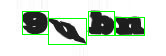

Actual Text: 9ubn
Predicted Text:  9ubn
...........................MATCH.............................
matches so far : 161/173
[INFO] processing image 202/400


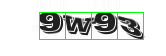

Actual Text: 9W93
Predicted Text:  9W93
...........................MATCH.............................
matches so far : 162/174
[INFO] processing image 203/400
[INFO] processing image 204/400


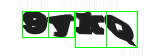

Actual Text: 9ykQ
Predicted Text:  9ykQ
...........................MATCH.............................
matches so far : 163/175
[INFO] processing image 205/400


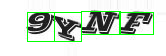

Actual Text: 9YNF
Predicted Text:  9YNF
...........................MATCH.............................
matches so far : 164/176
[INFO] processing image 206/400


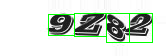

Actual Text: 9Z82
Predicted Text:  9Z82
...........................MATCH.............................
matches so far : 165/177
[INFO] processing image 207/400


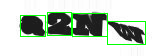

Actual Text: a2NW
Predicted Text:  a2NW
...........................MATCH.............................
matches so far : 166/178
[INFO] processing image 208/400


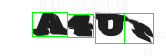

Actual Text: A4Ur
Predicted Text:  A4Ur
...........................MATCH.............................
matches so far : 167/179
[INFO] processing image 209/400


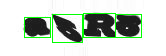

Actual Text: a5R8
Predicted Text:  a5R8
...........................MATCH.............................
matches so far : 168/180
[INFO] processing image 210/400


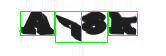

Actual Text: A78k
Predicted Text:  A78k
...........................MATCH.............................
matches so far : 169/181
[INFO] processing image 211/400


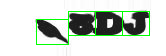

Actual Text: a8DJ
Predicted Text:  a8DJ
...........................MATCH.............................
matches so far : 170/182
[INFO] processing image 212/400


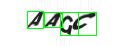

Actual Text: AAGC
Predicted Text:  AAGC
...........................MATCH.............................
matches so far : 171/183
[INFO] processing image 213/400


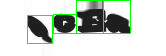

Actual Text: acEa
Predicted Text:  acEx
matches so far : 171/184
[INFO] processing image 214/400
[INFO] processing image 215/400


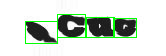

Actual Text: aCuc
Predicted Text:  aCuc
...........................MATCH.............................
matches so far : 172/185
[INFO] processing image 216/400


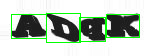

Actual Text: adqk
Predicted Text:  ADqk
...........................MATCH.............................
matches so far : 173/186
[INFO] processing image 217/400


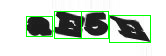

Actual Text: aE5E
Predicted Text:  aE5E
...........................MATCH.............................
matches so far : 174/187
[INFO] processing image 218/400


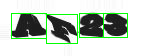

Actual Text: AF23
Predicted Text:  AF23
...........................MATCH.............................
matches so far : 175/188
[INFO] processing image 219/400


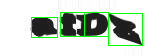

Actual Text: afdz
Predicted Text:  afDZ
...........................MATCH.............................
matches so far : 176/189
[INFO] processing image 220/400


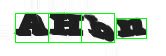

Actual Text: AHbn
Predicted Text:  AHbn
...........................MATCH.............................
matches so far : 177/190
[INFO] processing image 221/400
[INFO] processing image 222/400


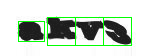

Actual Text: akv3
Predicted Text:  akv3
...........................MATCH.............................
matches so far : 178/191
[INFO] processing image 223/400


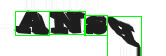

Actual Text: ANsq
Predicted Text:  ANsq
...........................MATCH.............................
matches so far : 179/192
[INFO] processing image 224/400


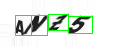

Actual Text: ANZ5
Predicted Text:  ANZ5
...........................MATCH.............................
matches so far : 180/193
[INFO] processing image 225/400


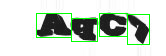

Actual Text: AqC7
Predicted Text:  AqC7
...........................MATCH.............................
matches so far : 181/194
[INFO] processing image 226/400


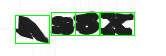

Actual Text: As8X
Predicted Text:  As8X
...........................MATCH.............................
matches so far : 182/195
[INFO] processing image 227/400


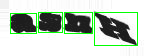

Actual Text: asnH
Predicted Text:  asnH
...........................MATCH.............................
matches so far : 183/196
[INFO] processing image 228/400
[INFO] processing image 229/400


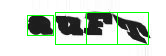

Actual Text: auFT
Predicted Text:  auFT
...........................MATCH.............................
matches so far : 184/197
[INFO] processing image 230/400


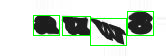

Actual Text: auw8
Predicted Text:  auw8
...........................MATCH.............................
matches so far : 185/198
[INFO] processing image 231/400


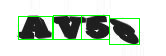

Actual Text: AV58
Predicted Text:  AV58
...........................MATCH.............................
matches so far : 186/199
[INFO] processing image 232/400
[INFO] processing image 233/400
[INFO] processing image 234/400


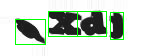

Actual Text: aXdj
Predicted Text:  aXdj
...........................MATCH.............................
matches so far : 187/200
[INFO] processing image 235/400
[INFO] processing image 236/400


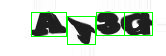

Actual Text: ay3g
Predicted Text:  Ay3G
...........................MATCH.............................
matches so far : 188/201
[INFO] processing image 237/400
[INFO] processing image 238/400


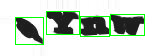

Actual Text: aYnw
Predicted Text:  aYnW
...........................MATCH.............................
matches so far : 189/202
[INFO] processing image 239/400


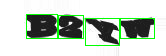

Actual Text: B2YW
Predicted Text:  B2Yw
...........................MATCH.............................
matches so far : 190/203
[INFO] processing image 240/400


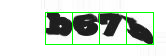

Actual Text: b67b
Predicted Text:  b67b
...........................MATCH.............................
matches so far : 191/204
[INFO] processing image 241/400
[INFO] processing image 242/400
[INFO] processing image 243/400
[INFO] processing image 244/400


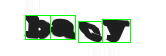

Actual Text: bacy
Predicted Text:  bacy
...........................MATCH.............................
matches so far : 192/205
[INFO] processing image 245/400
[INFO] processing image 246/400
[INFO] processing image 247/400


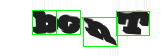

Actual Text: bcnT
Predicted Text:  bcnT
...........................MATCH.............................
matches so far : 193/206
[INFO] processing image 248/400


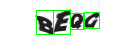

Actual Text: BEQG
Predicted Text:  BEQG
...........................MATCH.............................
matches so far : 194/207
[INFO] processing image 249/400


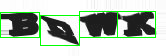

Actual Text: BEWK
Predicted Text:  BEWK
...........................MATCH.............................
matches so far : 195/208
[INFO] processing image 250/400


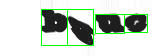

Actual Text: bguc
Predicted Text:  bguc
...........................MATCH.............................
matches so far : 196/209
[INFO] processing image 251/400


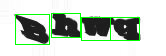

Actual Text: Bhwq
Predicted Text:  Bhwq
...........................MATCH.............................
matches so far : 197/210
[INFO] processing image 252/400


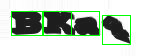

Actual Text: BKa4
Predicted Text:  BKa4
...........................MATCH.............................
matches so far : 198/211
[INFO] processing image 253/400


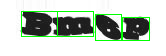

Actual Text: Bm6p
Predicted Text:  Bm6P
...........................MATCH.............................
matches so far : 199/212
[INFO] processing image 254/400


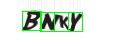

Actual Text: BNKY
Predicted Text:  BNKY
...........................MATCH.............................
matches so far : 200/213
[INFO] processing image 255/400


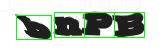

Actual Text: bnpB
Predicted Text:  bnPB
...........................MATCH.............................
matches so far : 201/214
[INFO] processing image 256/400


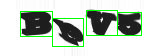

Actual Text: bpv5
Predicted Text:  BpV5
...........................MATCH.............................
matches so far : 202/215
[INFO] processing image 257/400


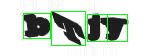

Actual Text: bTjy
Predicted Text:  bTfy
matches so far : 202/216
[INFO] processing image 258/400


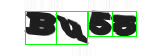

Actual Text: BU58
Predicted Text:  BU58
...........................MATCH.............................
matches so far : 203/217
[INFO] processing image 259/400


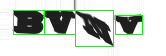

Actual Text: BVNv
Predicted Text:  BVNv
...........................MATCH.............................
matches so far : 204/218
[INFO] processing image 260/400


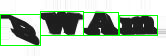

Actual Text: BwAm
Predicted Text:  PWAm
matches so far : 204/219
[INFO] processing image 261/400


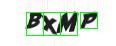

Actual Text: BXMP
Predicted Text:  BXMP
...........................MATCH.............................
matches so far : 205/220
[INFO] processing image 262/400


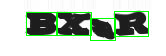

Actual Text: BXsR
Predicted Text:  BXsR
...........................MATCH.............................
matches so far : 206/221
[INFO] processing image 263/400


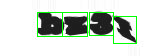

Actual Text: bz3f
Predicted Text:  bZ3f
...........................MATCH.............................
matches so far : 207/222
[INFO] processing image 264/400
[INFO] processing image 265/400


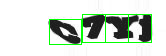

Actual Text: C7Yj
Predicted Text:  c7YN
matches so far : 207/223
[INFO] processing image 266/400
[INFO] processing image 267/400


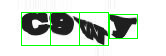

Actual Text: c9wy
Predicted Text:  c9Wy
...........................MATCH.............................
matches so far : 208/224
[INFO] processing image 268/400


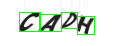

Actual Text: CADH
Predicted Text:  CADH
...........................MATCH.............................
matches so far : 209/225
[INFO] processing image 269/400
[INFO] processing image 270/400
[INFO] processing image 271/400


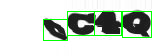

Actual Text: cC4Q
Predicted Text:  cC4Q
...........................MATCH.............................
matches so far : 210/226
[INFO] processing image 272/400


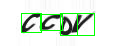

Actual Text: CCDV
Predicted Text:  CCDA
matches so far : 210/227
[INFO] processing image 273/400
[INFO] processing image 274/400
[INFO] processing image 275/400


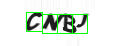

Actual Text: CNBJ
Predicted Text:  CNTU
matches so far : 210/228
[INFO] processing image 276/400
[INFO] processing image 277/400


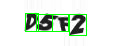

Actual Text: D5F2
Predicted Text:  D5F2
...........................MATCH.............................
matches so far : 211/229
[INFO] processing image 278/400
[INFO] processing image 279/400
[INFO] processing image 280/400
[INFO] processing image 281/400
[INFO] processing image 282/400
[INFO] processing image 283/400


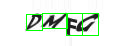

Actual Text: DMFG
Predicted Text:  DMF7
matches so far : 211/230
[INFO] processing image 284/400
[INFO] processing image 285/400


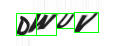

Actual Text: DWUV
Predicted Text:  DWUV
...........................MATCH.............................
matches so far : 212/231
[INFO] processing image 286/400


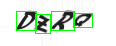

Actual Text: DZRQ
Predicted Text:  DZRQ
...........................MATCH.............................
matches so far : 213/232
[INFO] processing image 287/400


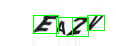

Actual Text: EA2V
Predicted Text:  EA2V
...........................MATCH.............................
matches so far : 214/233
[INFO] processing image 288/400
[INFO] processing image 289/400
[INFO] processing image 290/400
[INFO] processing image 291/400


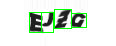

Actual Text: EJZG
Predicted Text:  EJZG
...........................MATCH.............................
matches so far : 215/234
[INFO] processing image 292/400
[INFO] processing image 293/400
[INFO] processing image 294/400


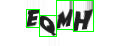

Actual Text: EQMH
Predicted Text:  EQMH
...........................MATCH.............................
matches so far : 216/235
[INFO] processing image 295/400


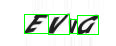

Actual Text: EVVG
Predicted Text:  EVVG
...........................MATCH.............................
matches so far : 217/236
[INFO] processing image 296/400
[INFO] processing image 297/400


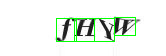

Actual Text: fHYW
Predicted Text:  fHYW
...........................MATCH.............................
matches so far : 218/237
[INFO] processing image 298/400


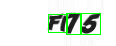

Actual Text: FI75
Predicted Text:  H75
matches so far : 218/238
[INFO] processing image 299/400
[INFO] processing image 300/400
[INFO] processing image 301/400
[INFO] processing image 302/400
[INFO] processing image 303/400


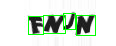

Actual Text: FNJN
Predicted Text:  FNJN
...........................MATCH.............................
matches so far : 219/239
[INFO] processing image 304/400
[INFO] processing image 305/400


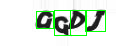

Actual Text: GGDJ
Predicted Text:  GGDJ
...........................MATCH.............................
matches so far : 220/240
[INFO] processing image 306/400


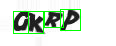

Actual Text: GKRP
Predicted Text:  GKRP
...........................MATCH.............................
matches so far : 221/241
[INFO] processing image 307/400


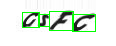

Actual Text: GSFC
Predicted Text:  CSFC
matches so far : 221/242
[INFO] processing image 308/400


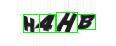

Actual Text: H4HB
Predicted Text:  H4HB
...........................MATCH.............................
matches so far : 222/243
[INFO] processing image 309/400
[INFO] processing image 310/400
[INFO] processing image 311/400
[INFO] processing image 312/400


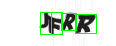

Actual Text: JFRR
Predicted Text:  JFRR
...........................MATCH.............................
matches so far : 223/244
[INFO] processing image 313/400
[INFO] processing image 314/400
[INFO] processing image 315/400
[INFO] processing image 316/400


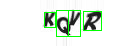

Actual Text: KQVR
Predicted Text:  KQYR
matches so far : 223/245
[INFO] processing image 317/400
[INFO] processing image 318/400


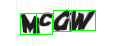

Actual Text: MCGW
Predicted Text:  MCGW
...........................MATCH.............................
matches so far : 224/246
[INFO] processing image 319/400
[INFO] processing image 320/400
[INFO] processing image 321/400
[INFO] processing image 322/400


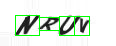

Actual Text: NRUV
Predicted Text:  NRUV
...........................MATCH.............................
matches so far : 225/247
[INFO] processing image 323/400


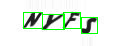

Actual Text: NYFS
Predicted Text:  NYFS
...........................MATCH.............................
matches so far : 226/248
[INFO] processing image 324/400


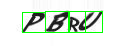

Actual Text: PBRU
Predicted Text:  PBRU
...........................MATCH.............................
matches so far : 227/249
[INFO] processing image 325/400
[INFO] processing image 326/400
[INFO] processing image 327/400


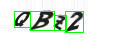

Actual Text: QBZ2
Predicted Text:  QBZ2
...........................MATCH.............................
matches so far : 228/250
[INFO] processing image 328/400


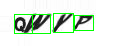

Actual Text: QWYP
Predicted Text:  MWYP
matches so far : 228/251
[INFO] processing image 329/400


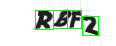

Actual Text: RBF2
Predicted Text:  RBF2
...........................MATCH.............................
matches so far : 229/252
[INFO] processing image 330/400


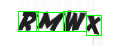

Actual Text: RMWX
Predicted Text:  RMWX
...........................MATCH.............................
matches so far : 230/253
[INFO] processing image 331/400
[INFO] processing image 332/400
[INFO] processing image 333/400


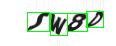

Actual Text: SW8D
Predicted Text:  SW8D
...........................MATCH.............................
matches so far : 231/254
[INFO] processing image 334/400


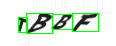

Actual Text: TBBF
Predicted Text:  TBBF
...........................MATCH.............................
matches so far : 232/255
[INFO] processing image 335/400


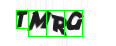

Actual Text: TMRG
Predicted Text:  TMRG
...........................MATCH.............................
matches so far : 233/256
[INFO] processing image 336/400


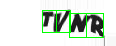

Actual Text: TVNR
Predicted Text:  TVNR
...........................MATCH.............................
matches so far : 234/257
[INFO] processing image 337/400


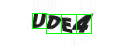

Actual Text: UDE4
Predicted Text:  UDE4
...........................MATCH.............................
matches so far : 235/258
[INFO] processing image 338/400


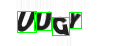

Actual Text: UUGY
Predicted Text:  UUGY
...........................MATCH.............................
matches so far : 236/259
[INFO] processing image 339/400
[INFO] processing image 340/400
[INFO] processing image 341/400
[INFO] processing image 342/400
[INFO] processing image 343/400


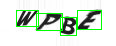

Actual Text: WPBE
Predicted Text:  WPBE
...........................MATCH.............................
matches so far : 237/260
[INFO] processing image 344/400
[INFO] processing image 345/400
[INFO] processing image 346/400
[INFO] processing image 347/400
[INFO] processing image 348/400


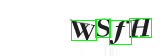

Actual Text: WSfH
Predicted Text:  WSfH
...........................MATCH.............................
matches so far : 238/261
[INFO] processing image 349/400
[INFO] processing image 350/400
[INFO] processing image 351/400
[INFO] processing image 352/400
[INFO] processing image 353/400
[INFO] processing image 354/400
[INFO] processing image 355/400
[INFO] processing image 356/400


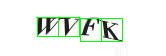

Actual Text: WVFK
Predicted Text:  WVFK
...........................MATCH.............................
matches so far : 239/262
[INFO] processing image 357/400


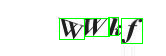

Actual Text: wwkf
Predicted Text:  WWkf
...........................MATCH.............................
matches so far : 240/263
[INFO] processing image 358/400


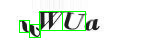

Actual Text: wWUa
Predicted Text:  avWU
matches so far : 240/264
[INFO] processing image 359/400
[INFO] processing image 360/400
[INFO] processing image 361/400
[INFO] processing image 362/400
[INFO] processing image 363/400
[INFO] processing image 364/400
[INFO] processing image 365/400
[INFO] processing image 366/400
[INFO] processing image 367/400
[INFO] processing image 368/400
[INFO] processing image 369/400
[INFO] processing image 370/400
[INFO] processing image 371/400
[INFO] processing image 372/400
[INFO] processing image 373/400
[INFO] processing image 374/400
[INFO] processing image 375/400
[INFO] processing image 376/400
[INFO] processing image 377/400
[INFO] processing image 378/400
[INFO] processing image 379/400
[INFO] processing image 380/400
[INFO] processing image 381/400
[INFO] processing image 382/400
[INFO] processing image 383/400
[INFO] processing image 384/400
[INFO] processing image 385/400
[INFO] processing image 386/400


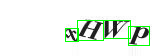

Actual Text: xHWP
Predicted Text:  xHWP
...........................MATCH.............................
matches so far : 241/265
[INFO] processing image 387/400
[INFO] processing image 388/400
[INFO] processing image 389/400
[INFO] processing image 390/400
[INFO] processing image 391/400
[INFO] processing image 392/400
[INFO] processing image 393/400
[INFO] processing image 394/400
[INFO] processing image 395/400
[INFO] processing image 396/400


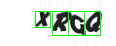

Actual Text: XRGQ
Predicted Text:  XRGQ
...........................MATCH.............................
matches so far : 242/266
[INFO] processing image 397/400


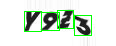

Actual Text: Y9Z3
Predicted Text:  Y9Z3
...........................MATCH.............................
matches so far : 243/267
[INFO] processing image 398/400
[INFO] processing image 399/400


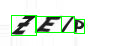

Actual Text: ZEIP
Predicted Text:  Z4IP
matches so far : 243/268
[INFO] processing image 400/400


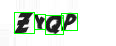

Actual Text: ZYQP
Predicted Text:  ZYQP
...........................MATCH.............................
matches so far : 244/269
accuracy: >>>>>>>>>>>>>>>>>>>>>>>>>>>>  0.9070631970260223


In [14]:
images(captcha_image_files_all)